#Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install sweetviz missingno shap lime

##Import libraries

In [ ]:
#basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import sweetviz as sv
from scipy.stats import kurtosis
from scipy.stats import skew
import missingno as ms
import pickle

#Models
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection, preprocessing, metrics
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV


#Lightgbm
import lightgbm as lgb

#Explainable IA
import shap
import lime
import lime.lime_tabular

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Define Functions

In [ ]:
#Functions

#Split dataframe by data types
def split_dataframe(dataframe):
  cat_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  cont_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  col = list(dataframe.columns)
  col.pop(0)
  col.pop(0)
  for c in col:
    if dataframe[c].dtypes == 'object':
      cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    elif dataframe[c].isin([0,1,'Nan']).all():
        cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    else:
      cont_dataframe = pd.concat([cont_dataframe, dataframe[c]], axis = 1)
  cat = cat_dataframe
  cont = cont_dataframe
  return cat, cont

#Organize aggregation of datasets
def organize_agg(dataframe, stat, name):
  columns = []
  for var in dataframe.columns.levels[0]:
    for stat in dataframe.columns.levels[1][:]:
      columns.append('%s_%s_%s' % (name, var, stat))
  dataframe.columns = columns
  return dataframe

#Number of missing values in the dataframe application
def missing_values(dataframe):
  number_MV = pd.DataFrame({'Count' : dataframe.isnull().sum(),
                          '%': dataframe.isnull().sum()/len(dataframe)})
  print(number_MV.astype(bool).sum(axis=0)[0], 'Columns with missing values')
  return number_MV.sort_values('Count', ascending=False)


#Plot ROC AUC Curve
def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1],'r--')
    plt.legend(loc="lower right")

#Plot Feature Importances
def plot_feature_importances(model):
    plt.figure(figsize=(20,20))

    fi_df = pd.DataFrame(model.feature_importances_, index=col[1:])
    fi_df = fi_df.rename(columns={0:'Feature importance'})
    fi_df.sort_values('Feature importance', ascending=True, inplace=True)

    ax = plt.subplot()
    ax.barh(list(fi_df.index), fi_df['Feature importance'])
    return fi_df

#Load datasets

Raw datasets from kaggle

In [ ]:
#Load Dataset
path = '/content/drive/MyDrive/DS/CreditRisk/home-credit-default-risk/'
application_train = pd.read_csv(path + 'application_train.csv')
bureau = pd.read_csv(path + 'bureau.csv')


Datasets obtained after the EDA has been performed

In [ ]:
path2 = '/content/drive/MyDrive/DS/CreditRisk/home-credit-default-risk/eda/'

In [ ]:
bureau_balance_id = pd.read_csv(path2+'bureau_balance_id.csv')
previous_application = pd.read_csv(path2+'previous_application.csv')
prev_cc_agg = pd.read_csv(path2+'prev_cc_agg.csv')

In [ ]:
installments_payments_agg = pd.read_csv(path2+'installments_payments_agg.csv')

In [ ]:
pos_agg = pd.read_csv(path2+'pos_agg.csv')

#Data Prep

##Application 

The first step for this data preparation step is to create a global dataset in which all the other dataset will be merged. This global dataset is built upon the application_train dataset with the selected features.

Analysing the EDA from the application_train dataset. These are the selected features:

In [ ]:
index_target = ['SK_ID_CURR', 'TARGET']

numerical_features = ['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'TOTALAREA_MODE',
 'LIVINGAREA_AVG',
 'APARTMENTS_AVG',
 'ENTRANCES_AVG',
 'ELEVATORS_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

#Columns with categorical data for the application test dataframe
categorial_features = ['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [ ]:
df = application_train[index_target+ numerical_features + categorial_features]

Some features deal with time data, such as days or months. These features were provided as negative values starting from the application time. To make it more intuitive, these features were converted to positive values.

In [ ]:
time_features = ['DAYS_BIRTH',
                  'DAYS_EMPLOYED',
                  'DAYS_REGISTRATION',
                  'DAYS_ID_PUBLISH', 
                  'DAYS_LAST_PHONE_CHANGE']

In [ ]:
for i in time_features:
  df[i] = df[i]/-365


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now, the missing values from this dataset are going to be filled in. First, the categorical missing values are going to be replaced by a tag 'not informed'.

In [ ]:
missing_values(df[categorial_features])

4 Columns with missing values


Count         %
FONDKAPREMONT_MODE  210295  0.683862
WALLSMATERIAL_MODE  156341  0.508408
HOUSETYPE_MODE      154297  0.501761
OCCUPATION_TYPE      96391  0.313455
NAME_CONTRACT_TYPE       0  0.000000
CODE_GENDER              0  0.000000
ORGANIZATION_TYPE        0  0.000000

In [ ]:
for i in categorial_features:
    df[i].fillna('Not informed', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Following, the missing values for the numerical features are examined. While some features present a low number of missing values (less than 5%), others have much more (reaching more than 50%). For each level, a treatment will be applied.

In [ ]:
missing_values(df[numerical_features])

24 Columns with missing values


Count         %
EXT_SOURCE_1                 173378  0.563811
ELEVATORS_AVG                163891  0.532960
APARTMENTS_AVG               156061  0.507497
ENTRANCES_AVG                154828  0.503488
LIVINGAREA_AVG               154350  0.501933
FLOORSMAX_AVG                153020  0.497608
YEARS_BEGINEXPLUATATION_AVG  150007  0.487810
TOTALAREA_MODE               148431  0.482685
EXT_SOURCE_3                  60965  0.198253
AMT_REQ_CREDIT_BUREAU_QRT     41519  0.135016
AMT_REQ_CREDIT_BUREAU_MON     41519  0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    41519  0.135016
AMT_REQ_CREDIT_BUREAU_DAY     41519  0.135016
AMT_REQ_CREDIT_BUREAU_HOUR    41519  0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    41519  0.135016
DEF_30_CNT_SOCIAL_CIRCLE       1021  0.003320
OBS_30_CNT_SOCIAL_CIRCLE       1021  0.003320
DEF_60_CNT_SOCIAL_CIRCLE       1021  0.003320
OBS_60_CNT_SOCIAL_CIRCLE       1021  0.003320
EXT_SOURCE_2                    660  0.002146
AMT_GOODS_PRICE                 278  0.000904
AMT_ANNUITY                      12  0.000039
CNT_FAM_MEMBERS                   2  0.000007
DAYS_LAST_PHONE_CHANGE            1  0.000003
DAYS_ID_PUBLISH                   0  0.000000
DAYS_REGISTRATION                 0  0.000000
DAYS_EMPLOYED                     0  0.000000
REGION_RATING_CLIENT              0  0.000000
HOUR_APPR_PROCESS_START           0  0.000000
REGION_RATING_CLIENT_W_CITY       0  0.000000
AMT_INCOME_TOTAL                  0  0.000000
DAYS_BIRTH                        0  0.000000
REGION_POPULATION_RELATIVE        0  0.000000
AMT_CREDIT                        0  0.000000
CNT_CHILDREN                      0  0.000000

For features with less than 5% of missing values, the data will be filled with the mean value of the feature.

In [ ]:
numerical_mv = missing_values(df[numerical_features])

l_mv_5per = list(numerical_mv[numerical_mv['%']<=0.05].index)

24 Columns with missing values


In [ ]:
for i in l_mv_5per:
    df[i].fillna(df[i].mean(), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Features with a higher number of missing values will be treated through imputation methods.

For the EXT_SOURCE_1 the KNN method can be applied.

In [ ]:
columns_imputation_knn = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'HOUR_APPR_PROCESS_START',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'AMT_INCOME_TOTAL', 'CNT_CHILDREN']

In [ ]:
# #Estimator
# imputer =  KNNImputer(n_neighbors=6)

# #Imputation of EXT_SOURCE_1 data
# imputation_knn = imputer.fit_transform(df[columns_imputation_knn])

In [ ]:
#Organize results has a dataframe
# application_impute_knn = pd.DataFrame(imputation_knn, columns=columns_imputation_knn)

In [ ]:
path3 = '/content/drive/MyDrive/DS/CreditRisk/home-credit-default-risk/dataprep/'

In [ ]:
application_impute_knn = pd.read_csv(path3 + 'application_knn.csv')

In [ ]:
df['EXT_SOURCE_1'] = application_impute_knn['EXT_SOURCE_1']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The missing values for the remaining features were filled using Multivariate Imputation by Chained Equation (MICE) through the IterativeImputer class from the sklearn library;.

In [ ]:
impute_br = IterativeImputer(BayesianRidge())

In this imputation, the EXT_SOURCE_1 feature (filled with the KNN imputation) was removed to avoid biases.

In [ ]:
impute_features = numerical_features

In [ ]:
impute_features.remove('EXT_SOURCE_1')

These numerical features were removed to avoid the imputation of negative values. In such features, there cannot be negative values given that these features are normalized in the range between zero and 1.

In [ ]:
normalized_features = ['EXT_SOURCE_3',
                       'APARTMENTS_AVG',
                      'FLOORSMAX_AVG',
                      'TOTALAREA_MODE',
                      'LIVINGAREA_AVG',
                      'ELEVATORS_AVG',
                      'AMT_REQ_CREDIT_BUREAU_HOUR',
                      'AMT_REQ_CREDIT_BUREAU_DAY',
                      'AMT_REQ_CREDIT_BUREAU_WEEK',
                      'AMT_REQ_CREDIT_BUREAU_MON',
                      'AMT_REQ_CREDIT_BUREAU_QRT',
                      'AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
for i in normalized_features:
  impute_features.remove(i)

In [ ]:
numerical_impute_br = impute_br.fit_transform(df[impute_features])

In [ ]:
#Organize results has a dataframe
df_imputed = pd.DataFrame(numerical_impute_br, columns=numerical_features)

In [ ]:
df_imputed = pd.concat([df[index_target+categorial_features], df_imputed], axis=1)

Another imputation was conducted, but this time, limiting the minimum value of the features to zero.

In [ ]:
impute_br_norm = IterativeImputer(BayesianRidge(), min_value=0)

In [ ]:
columns_imputation_knn.remove('EXT_SOURCE_1')

In [ ]:
columns_imputation_normalized = columns_imputation_knn + normalized_features

In [ ]:
normalized_impute_br = impute_br_norm.fit_transform(df[columns_imputation_normalized])

In [ ]:
#Organize results has a dataframe
df_imputed_norm = pd.DataFrame(normalized_impute_br, columns=columns_imputation_normalized)

In [ ]:
df_imputed = pd.concat([df_imputed, df_imputed_norm[normalized_features]], axis=1)

In [ ]:
df_imputed['EXT_SOURCE_1'] = application_impute_knn['EXT_SOURCE_1']

In [ ]:
del df_imputed_norm 

Using the sweetviz is also possible to compare the dataset before and after the imputation of the missing values. This process can help to shed light on possible bias introduced by imputations techniques.

In [ ]:
#compare = sv.compare([application_train, 'Raw Dataset'], [df_imputed, 'Dataset with imputation'], target_feat = 'TARGET', pairwise_analysis='off')
#compare.show_html('compare.html')

##Aggregation of other datasets

###Bureau

As observed in the EDA step, some features of this dataset have more than 60% of missing data; therefore, these features are going to be removed. Through the report generated by the sweetviz, the features that have a higher correlation (or association in the case of the categorical ones) were selected.

In [ ]:
selected_colums_bureau = ['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'DAYS_CREDIT', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE']

Some of these features are categorical and aggregation of rows is needed. These categorical features have to be encoded before the aggregation.


Treatment of time relative features

In [ ]:
df_bureau = bureau[selected_colums_bureau]

In [ ]:
time_features = ['DAYS_CREDIT',
                 'DAYS_CREDIT_UPDATE']

In [ ]:
for i in time_features:
  df_bureau[i] = df_bureau[i]/-365


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
for i in time_features:
  df_bureau.loc[lambda df_bureau: df_bureau[i] < 0, [i]] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The feature DAYS_CREDIT_UPDATE has information on 'How many days before loan application did last information about the Credit Bureau credit come'. Some values are greater than 100 years. This is unrealistic. Therefore, these values were set to represent a value for misinformation on the data equal to -99999.

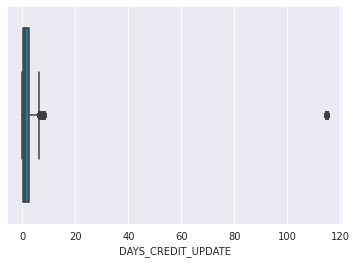

In [ ]:
sns.boxplot(df_bureau['DAYS_CREDIT_UPDATE'])

In [ ]:
for i in time_features:
  df_bureau.loc[lambda df_bureau: df_bureau[i] > 100, [i]] = -99999


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data aggregation

In [ ]:
df_bureau = pd.get_dummies(df_bureau)

In [ ]:
df_bureau = df_bureau.drop('SK_ID_BUREAU', axis=1).groupby('SK_ID_CURR').agg(['mean'])

In [ ]:
df_bureau = organize_agg(df_bureau, 'mean', 'Bureau')

In [ ]:
missing_values(df_bureau)

0 Columns with missing values


Count    %
Bureau_DAYS_CREDIT_mean                                 0  0.0
Bureau_CREDIT_TYPE_Interbank credit_mean                0  0.0
Bureau_CREDIT_TYPE_Real estate loan_mean                0  0.0
Bureau_CREDIT_TYPE_Mortgage_mean                        0  0.0
Bureau_CREDIT_TYPE_Mobile operator loan_mean            0  0.0
Bureau_CREDIT_TYPE_Microloan_mean                       0  0.0
Bureau_CREDIT_TYPE_Loan for working capital rep...      0  0.0
Bureau_CREDIT_TYPE_Loan for the purchase of equ...      0  0.0
Bureau_CREDIT_TYPE_Loan for purchase of shares ...      0  0.0
Bureau_CREDIT_TYPE_Loan for business developmen...      0  0.0
Bureau_CREDIT_TYPE_Credit card_mean                     0  0.0
Bureau_DAYS_CREDIT_UPDATE_mean                          0  0.0
Bureau_CREDIT_TYPE_Consumer credit_mean                 0  0.0
Bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean       0  0.0
Bureau_CREDIT_TYPE_Car loan_mean                        0  0.0
Bureau_CREDIT_TYPE_Another type of loan_mean            0  0.0
Bureau_CREDIT_ACTIVE_Sold_mean                          0  0.0
Bureau_CREDIT_ACTIVE_Closed_mean                        0  0.0
Bureau_CREDIT_ACTIVE_Bad debt_mean                      0  0.0
Bureau_CREDIT_ACTIVE_Active_mean                        0  0.0
Bureau_CREDIT_TYPE_Unknown type of loan_mean            0  0.0

In [ ]:
df_train = pd.merge(df_imputed, df_bureau, on='SK_ID_CURR', how='left', indicator=True)

In [ ]:
df_train['_merge'] = df_train['_merge']=='left_only'
df_train.rename({'_merge': 'Bureau'}, axis = 1, inplace=True)

###Bureau Balance

The Bureau Balance data upload was preprocessed in the EDA step. Another aggregation had to be applied to merge this one with the training dataset. 

In [ ]:
bureau_balance_id = bureau_balance_id.drop('Unnamed: 0', axis=1)

In [ ]:
bureau_balance_id.drop('TARGET', axis=1, inplace=True)

In [ ]:
bureau_balance_id = pd.merge(bureau_balance_id, bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], how = 'left', on='SK_ID_BUREAU')

In [ ]:
bureau_balance_id = bureau_balance_id.dropna(axis=0,subset=['SK_ID_CURR']).groupby('SK_ID_CURR').agg(['mean'])

In [ ]:
bureau_balance_id = organize_agg(bureau_balance_id, 'mean', 'Bureau_Balance')

In [ ]:
bureau_balance_id.drop('Bureau_Balance_SK_ID_BUREAU_mean', axis=1, inplace=True)

Check for missing values in the dataset to be merged with the training dataset.

In [ ]:
missing_values(bureau_balance_id)

0 Columns with missing values


Count    %
Bureau_Balance_bureau_balance_STATUS_0_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_1_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_2_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_3_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_4_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_5_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_C_mean_mean        0  0.0
Bureau_Balance_bureau_balance_STATUS_X_mean_mean        0  0.0
Bureau_Balance_bureau_balance_MONTHS_BALANCE_co...      0  0.0

Merge with the training dataset

In [ ]:
df_train = pd.merge(df_train, bureau_balance_id, on='SK_ID_CURR', how='left', indicator=True)
df_train['_merge'] = df_train['_merge']=='left only'

In [ ]:
df_train.rename({'_merge': 'Bureau_Balance'}, axis=1, inplace=True)

In [ ]:
df_train

SK_ID_CURR  ...  Bureau_Balance
0           100002  ...           False
1           100003  ...           False
2           100004  ...           False
3           100006  ...           False
4           100007  ...           False
...            ...  ...             ...
307506      456251  ...           False
307507      456252  ...           False
307508      456253  ...           False
307509      456254  ...           False
307510      456255  ...           False

[307511 rows x 76 columns]

###Previous application data

This dataset was previously analysed and the following features were selected:

In [ ]:
previous_application.drop('Unnamed: 0', axis=1, inplace=True )

In [ ]:
#Selected Features
selected_columns_categorical = ['CODE_REJECT_REASON', 'PRODUCT_COMBINATION', 'NAME_CONTRACT_STATUS']
selected_columns_numerical = ['DAYS_FIRST_DRAWING', 'DAYS_DECISION', 'RATE_DOWN_PAYMENT', 'AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'CNT_PAYMENT', 'DAYS_FIRST_DUE']
head_columns = ['SK_ID_CURR', 'SK_ID_PREV']

selected_columns = head_columns+selected_columns_categorical+selected_columns_numerical
pa_final = previous_application[selected_columns]

To prepare and aggregate the data, first, the features were divided according to their type, as numerical or categorical.

In [ ]:
pa_categorical, pa_numerical = split_dataframe(pa_final)

Categorical data

In [ ]:
pa_categorical = pd.get_dummies(pa_categorical)

pa_categorical_agg = pa_categorical.groupby('SK_ID_CURR', as_index=False).agg(['mean'])

In [ ]:
pa_categorial_agg = organize_agg(pa_categorical_agg, 'mean', 'PA')

In [ ]:
pa_categorial_agg.drop('PA_SK_ID_PREV_mean', axis=1, inplace=True)

Numerical data


Some of the features represent values relative to a timestamp counted as negative values. Therefore, positive values in such cases are a representation of missing values. These features information were transformed into positive values, such that negative values become a representation of missing values.

In [ ]:
time_features = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_DECISION' ]

In [ ]:
for i in time_features:
  pa_numerical[i] = pa_numerical[i]/-365

In [ ]:
for i in time_features:
  pa_numerical.loc[lambda pa_numerical: pa_numerical[i] < 0, [i]] = -99999

In [ ]:
for i in ['RATE_DOWN_PAYMENT', 'AMT_DOWN_PAYMENT']:
  pa_numerical.loc[lambda pa_numerical: pa_numerical[i] < 0, [i]] = 0

Aggregation of clients in the previous application dataset

In [ ]:
pa_numerical = pa_numerical.groupby('SK_ID_CURR', as_index=False).agg(['mean'])

In [ ]:
pa_numerical = organize_agg(pa_numerical, 'mean', 'PA')

In [ ]:
pa_numerical.drop('PA_SK_ID_PREV_mean', axis=1, inplace=True)

In [ ]:
pa_final = pd.merge(pa_numerical, pa_categorial_agg, on='SK_ID_CURR', how='left')

In [ ]:
pa_final.describe()

PA_DAYS_FIRST_DRAWING_mean  ...  PA_NAME_CONTRACT_STATUS_Unused offer_mean
count               337340.000000  ...                              338857.000000
mean                -93991.267833  ...                                   0.014921
std                  14960.916513  ...                                   0.068630
min                 -99999.000000  ...                                   0.000000
25%                 -99999.000000  ...                                   0.000000
50%                 -99999.000000  ...                                   0.000000
75%                 -99999.000000  ...                                   0.000000
max                      8.005479  ...                                   1.000000

[8 rows x 37 columns]

Check for missing values in the dataset to be merged

In [ ]:
missing_values(pa_final)

6 Columns with missing values


Count         %
PA_RATE_DOWN_PAYMENT_mean                           20104  0.059329
PA_AMT_DOWN_PAYMENT_mean                            20104  0.059329
PA_DAYS_FIRST_DRAWING_mean                           1517  0.004477
PA_DAYS_FIRST_DUE_mean                               1517  0.004477
PA_AMT_ANNUITY_mean                                   480  0.001417
PA_CNT_PAYMENT_mean                                   478  0.001411
PA_PRODUCT_COMBINATION_POS mobile with interest...      0  0.000000
PA_PRODUCT_COMBINATION_Cash X-Sell: low_mean            0  0.000000
PA_PRODUCT_COMBINATION_Cash X-Sell: middle_mean         0  0.000000
PA_PRODUCT_COMBINATION_POS household with inter...      0  0.000000
PA_PRODUCT_COMBINATION_POS household without in...      0  0.000000
PA_PRODUCT_COMBINATION_POS industry with intere...      0  0.000000
PA_PRODUCT_COMBINATION_POS industry without int...      0  0.000000
PA_PRODUCT_COMBINATION_POS others without inter...      0  0.000000
PA_PRODUCT_COMBINATION_POS mobile without inter...      0  0.000000
PA_PRODUCT_COMBINATION_POS other with interest_...      0  0.000000
PA_PRODUCT_COMBINATION_Cash Street: middle_mean         0  0.000000
PA_NAME_CONTRACT_STATUS_Approved_mean                   0  0.000000
PA_NAME_CONTRACT_STATUS_Canceled_mean                   0  0.000000
PA_NAME_CONTRACT_STATUS_Refused_mean                    0  0.000000
PA_PRODUCT_COMBINATION_Cash X-Sell: high_mean           0  0.000000
PA_PRODUCT_COMBINATION_Cash_mean                        0  0.000000
PA_PRODUCT_COMBINATION_Cash Street: low_mean            0  0.000000
PA_PRODUCT_COMBINATION_Cash Street: high_mean           0  0.000000
PA_DAYS_DECISION_mean                                   0  0.000000
PA_PRODUCT_COMBINATION_Card X-Sell_mean                 0  0.000000
PA_PRODUCT_COMBINATION_Card Street_mean                 0  0.000000
PA_CODE_REJECT_REASON_XNA_mean                          0  0.000000
PA_CODE_REJECT_REASON_XAP_mean                          0  0.000000
PA_CODE_REJECT_REASON_VERIF_mean                        0  0.000000
PA_CODE_REJECT_REASON_SYSTEM_mean                       0  0.000000
PA_CODE_REJECT_REASON_SCOFR_mean                        0  0.000000
PA_CODE_REJECT_REASON_SCO_mean                          0  0.000000
PA_CODE_REJECT_REASON_LIMIT_mean                        0  0.000000
PA_CODE_REJECT_REASON_HC_mean                           0  0.000000
PA_CODE_REJECT_REASON_CLIENT_mean                       0  0.000000
PA_NAME_CONTRACT_STATUS_Unused offer_mean               0  0.000000

The missing values data was filled by the mean given its low amount.

In [ ]:
pa_final.fillna(pa_final.mean(), inplace=True)

Merge with the training dataset

In [ ]:
df_train = pd.merge(df_train, pa_final, on='SK_ID_CURR', how='left', indicator=True)
df_train['_merge'] = df_train['_merge']=='left only'

In [ ]:
df_train.rename({'_merge': 'PA'}, axis=1, inplace=True)

###Credit Card Balance

In [ ]:
prev_cc_agg.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
prev_cc_agg_test = prev_cc_agg.groupby('SK_ID_CURR', as_index=False).agg(['mean'])

In [ ]:
prev_cc_agg_test = organize_agg(prev_cc_agg_test, 'mean', 'CC_')

In [ ]:
prev_cc_agg_test

CC__SK_ID_PREV_mean  ...  CC__TARGET_mean
SK_ID_CURR                       ...                 
100006                1489396.0  ...              0.0
100011                1843384.0  ...              0.0
100013                2038692.0  ...              NaN
100021                2594025.0  ...              0.0
100023                1499902.0  ...              0.0
...                         ...  ...              ...
456244                2181926.0  ...              0.0
456246                1079732.0  ...              0.0
456247                1595171.0  ...              0.0
456248                2743495.0  ...              0.0
456250                1794451.0  ...              NaN

[103558 rows x 62 columns]

In [ ]:
cc_selected_feat = ['CC__prev_cc_agg_MONTHS_BALANCE_max_mean',
                    'CC__prev_cc_agg_AMT_BALANCE_max_mean',
                    'CC__prev_cc_agg_AMT_BALANCE_min_mean',
                    'CC__prev_cc_agg_AMT_BALANCE_mean_mean',
                    'CC__prev_cc_agg_AMT_RECIVABLE_max_mean',
                    'CC__prev_cc_agg_AMT_RECIVABLE_min_mean',
                    'CC__prev_cc_agg_AMT_RECIVABLE_mean_mean',
                    'CC__prev_cc_agg_CNT_DRAWINGS_CURRENT_max_mean',
                    'CC__prev_cc_agg_CNT_DRAWINGS_CURRENT_min_mean',
                    'CC__prev_cc_agg_CNT_DRAWINGS_CURRENT_mean_mean',
                    'CC__prev_cc_agg_AMT_INST_MIN_REGULARITY_max_mean',
                    'CC__prev_cc_agg_AMT_INST_MIN_REGULARITY_min_mean',
                    'CC__prev_cc_agg_AMT_INST_MIN_REGULARITY_mean_mean',
                    'CC__prev_cc_agg_AMT_DRAWINGS_CURRENT_max_mean',
                    'CC__prev_cc_agg_AMT_DRAWINGS_CURRENT_min_mean',
                    'CC__prev_cc_agg_AMT_DRAWINGS_CURRENT_mean_mean']

In [ ]:
prev_cc_agg = prev_cc_agg_test[cc_selected_feat]

Merge with the training dataset

In [ ]:
df_train = pd.merge(df_train, prev_cc_agg, on='SK_ID_CURR', how='left', indicator=True)
df_train['_merge'] = df_train['_merge']=='left only'

In [ ]:
df_train.rename({'_merge': 'CC_Balance'}, axis=1, inplace=True)

###Instalments dataset

The following features were selected according to their correlation with the target variable. This analysis was based on the results from the sweetviz report

In [ ]:
installments_payments_agg.drop('Unnamed: 0', axis=1,inplace=True )

In [ ]:
selected_columns_ip = ['SK_ID_CURR', 'installments_DAYS_ENTRY_PAYMENT_mean', 'installments_DAYS_INSTALMENT_mean', 'installments_NUM_INSTALMENT_NUMBER_mean', 'installments_AMT_INSTALMENT_mean']
installments_payments_agg = installments_payments_agg[selected_columns_ip]

In [ ]:
time_features = [ 'installments_DAYS_ENTRY_PAYMENT_mean', 'installments_DAYS_INSTALMENT_mean' ]

In [ ]:
for i in time_features:
  installments_payments_agg[i] = installments_payments_agg[i]/-365

In [ ]:
installments_payments_agg = installments_payments_agg.groupby('SK_ID_CURR', as_index=False).agg(['mean'])

Data aggregation

In [ ]:
installments_payments_agg = organize_agg(installments_payments_agg, 'mean', 'Instalments')

Check for missing values in the dataset to be merged

In [ ]:
missing_values(installments_payments_agg)

1 Columns with missing values


Count         %
Instalments_installments_DAYS_ENTRY_PAYMENT_mea...      9  0.000027
Instalments_installments_DAYS_INSTALMENT_mean_mean      0  0.000000
Instalments_installments_NUM_INSTALMENT_NUMBER_...      0  0.000000
Instalments_installments_AMT_INSTALMENT_mean_mean       0  0.000000

The missing values data was filled by the mean given its low amount.

In [ ]:
installments_payments_agg.fillna(installments_payments_agg.mean(), inplace=True)

Merge with the training dataset

In [ ]:
df_train = pd.merge(df_train, installments_payments_agg, on='SK_ID_CURR', how = 'left', indicator=True)
df_train['_merge'] = df_train['_merge']=='left_only'
df_train.rename({'_merge': 'Instalments'}, axis = 1, inplace=True)

###POS Dataset

This dataset requires the same aggregation as the previous one to be merged with the main training dataset.

In [ ]:
pos_agg.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
selected_columns_pos = ['SK_ID_CURR', 'pos_MONTHS_BALANCE_min', 'pos_CNT_INSTALMENT_min', 'pos_CNT_INSTALMENT_FUTURE_min', 'pos_SK_DPD_DEF_max']

In [ ]:
pos_agg = pos_agg[selected_columns_pos]

In [ ]:
time_features = [ 'pos_MONTHS_BALANCE_min' ]

In [ ]:
for i in time_features:
  pos_agg[i] = pos_agg[i]/-12

In [ ]:
pos_agg = pos_agg.groupby('SK_ID_CURR', as_index=False).agg(['min', 'max'])

In [ ]:
pos_agg = organize_agg(pos_agg, ['min', 'max'], '')

Check for missing values in the dataset to be merged

In [ ]:
missing_values(pos_agg)

4 Columns with missing values


Count         %
_pos_CNT_INSTALMENT_min_min            28  0.000083
_pos_CNT_INSTALMENT_min_max            28  0.000083
_pos_CNT_INSTALMENT_FUTURE_min_min     28  0.000083
_pos_CNT_INSTALMENT_FUTURE_min_max     28  0.000083
_pos_MONTHS_BALANCE_min_min             0  0.000000
_pos_MONTHS_BALANCE_min_max             0  0.000000
_pos_SK_DPD_DEF_max_min                 0  0.000000
_pos_SK_DPD_DEF_max_max                 0  0.000000

The missing values data was filled by the mean given its low amount.

In [ ]:
pos_agg.fillna(pos_agg.mean(), inplace=True)

Merge with the training dataset

In [ ]:
df_train = pd.merge(df_train, pos_agg, on='SK_ID_CURR', how = 'left', indicator=True)
df_train['_merge'] = df_train['_merge']=='left_only'
df_train.rename({'_merge': 'POS'}, axis = 1, inplace=True)

##Missing values in the final dataframe

Multiple datasets were merged with the main training dataset. However, not all clients from the application dataset are present in other datasets. Therefore, when these different datasets were merged, the feature values for clients that are only in the application dataset are presented as 'NaN'. These missing values have to be filled in before the model training step.

In [ ]:
df_min = pd.to_numeric(df_train.min(), errors='coerce').to_frame(name='min')

In [ ]:
df_min.dropna(inplace=True)

In [ ]:
df_min[df_min['min']<0]

min
DAYS_EMPLOYED                                   -1000.665753
Bureau_DAYS_CREDIT_UPDATE_mean                 -99999.000000
PA_DAYS_FIRST_DRAWING_mean                     -99999.000000
PA_DAYS_FIRST_DUE_mean                         -99999.000000
CC__prev_cc_agg_MONTHS_BALANCE_max_mean            -5.000000
CC__prev_cc_agg_AMT_BALANCE_min_mean          -420250.185000
CC__prev_cc_agg_AMT_BALANCE_mean_mean           -2930.232558
CC__prev_cc_agg_AMT_RECIVABLE_min_mean        -420250.185000
CC__prev_cc_agg_AMT_RECIVABLE_mean_mean         -2930.232558
CC__prev_cc_agg_AMT_DRAWINGS_CURRENT_min_mean   -6211.620000

In [ ]:
df_train[list(missing_values(df_train)[missing_values(df_train)['%']>0].index)].min().min()

95 Columns with missing values
95 Columns with missing values


-420250.18499999994

In [ ]:
#report_final = sv.analyze(df_train, target_feat='TARGET', pairwise_analysis='off')

In [ ]:
#report_final.show_html('Df_train.html')

In [ ]:
timely = ['Bureau_DAYS_CREDIT_mean',
          'Bureau_DAYS_CREDIT_UPDATE_mean',
          '_pos_MONTHS_BALANCE_min_max',
          '_pos_MONTHS_BALANCE_min_min',
          'PA_AMT_DOWN_PAYMENT_mean',
          'PA_RATE_DOWN_PAYMENT_mean',
          'PA_DAYS_DECISION_mean',
          'PA_DAYS_FIRST_DRAWING_mean',
          'PA_DAYS_FIRST_DUE_mean',
          'Instalments_installments_DAYS_ENTRY_PAYMENT_mean_mean',
          'Instalments_installments_DAYS_INSTALMENT_mean_mean',
]

In [ ]:
df_train[timely].min()

Bureau_DAYS_CREDIT_mean                                      0.000000
Bureau_DAYS_CREDIT_UPDATE_mean                          -99999.000000
_pos_MONTHS_BALANCE_min_max                                  0.083333
_pos_MONTHS_BALANCE_min_min                                  0.083333
PA_AMT_DOWN_PAYMENT_mean                                     0.000000
PA_RATE_DOWN_PAYMENT_mean                                    0.000000
PA_DAYS_DECISION_mean                                        0.005479
PA_DAYS_FIRST_DRAWING_mean                              -99999.000000
PA_DAYS_FIRST_DUE_mean                                  -99999.000000
Instalments_installments_DAYS_ENTRY_PAYMENT_mean_mean        0.008219
Instalments_installments_DAYS_INSTALMENT_mean_mean           0.008219
dtype: float64

Missing Values

In [ ]:
missing_values(df_train)

95 Columns with missing values


Count         %
CC__prev_cc_agg_CNT_DRAWINGS_CURRENT_mean_mean  220606  0.717392
CC__prev_cc_agg_AMT_DRAWINGS_CURRENT_mean_mean  220606  0.717392
CC__prev_cc_agg_MONTHS_BALANCE_max_mean         220606  0.717392
CC__prev_cc_agg_AMT_BALANCE_max_mean            220606  0.717392
CC__prev_cc_agg_AMT_BALANCE_min_mean            220606  0.717392
...                                                ...       ...
DEF_60_CNT_SOCIAL_CIRCLE                             0  0.000000
OBS_60_CNT_SOCIAL_CIRCLE                             0  0.000000
DEF_30_CNT_SOCIAL_CIRCLE                             0  0.000000
OBS_30_CNT_SOCIAL_CIRCLE                             0  0.000000
POS                                                  0  0.000000

[145 rows x 2 columns]

In [ ]:
df_train.fillna(value=-99999, inplace=True)

In [ ]:
df_train

SK_ID_CURR  TARGET  ...  _pos_SK_DPD_DEF_max_max    POS
0           100002       1  ...                      0.0  False
1           100003       0  ...                      0.0  False
2           100004       0  ...                      0.0  False
3           100006       0  ...                      0.0  False
4           100007       0  ...                      0.0  False
...            ...     ...  ...                      ...    ...
307506      456251       0  ...                      0.0  False
307507      456252       0  ...                      0.0  False
307508      456253       0  ...                      5.0  False
307509      456254       1  ...                      0.0  False
307510      456255       0  ...                      5.0  False

[307511 rows x 145 columns]

#Model training

###First run

####Encoding of features from the application dataset before the training of the model.

In [ ]:
to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

In [ ]:
df_en_one = pd.get_dummies(df_train, columns=['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'])

In [ ]:
df_not_en = df_train.copy()

In [ ]:
df_cat = df_train

In [ ]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 145 entries, SK_ID_CURR to POS
dtypes: bool(6), float64(130), int64(2), object(7)
memory usage: 330.2+ MB


In [ ]:
for i in to_encode:
  df_cat[i] = df_cat[i].astype('category')
  df_cat[i]=df_cat[i].cat.codes


Splitting the dataset into training and test datasets.

In [ ]:
#Dataframe split

x_train, x_test, y_train, y_test = train_test_split(df_train.iloc[:,2:], df_train.iloc[:,1], random_state = 16)

col = list(df.columns)
col.pop(0)
col

x = df_train[col]
y = y_train

Definition of the estimator

In [ ]:
clf = lgb.LGBMClassifier(
              learning_rate = .05, #so called `eta` value
              max_depth = 6,
              min_child_weight = 4,
              subsample =  0.7,
              colsample_bytree = 0.7,
              n_estimators= 500,
)

clf.fit(x_train,y_train, categorical_feature=to_encode)

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE']


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.05, max_depth=6,
               min_child_samples=20, min_child_weight=4, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

Evaluation of the results using the ROC AUC curve

0.7728432601691044


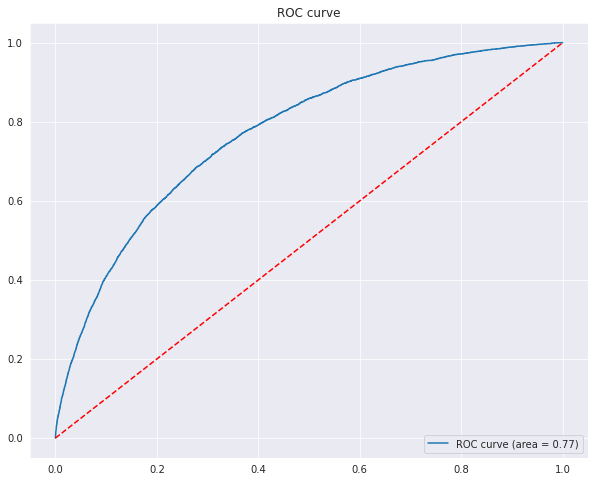

In [ ]:
y_predict_lgbm = clf.predict_proba(x_test)[:,1]
plot_roc(y_test, y_predict_lgbm)

###Model Tuning

Tuning of the parameters for the LGBModel using the randomized search cross validation method.

####First attempt

In [ ]:
#Dataframe split

x_train, x_test, y_train, y_test = train_test_split(df_train.iloc[:,2:], df_train.iloc[:,1], random_state = 16)

col = list(df_train.columns)
col.pop(0)
col

x = df_train[col]
y = y_train

Determination of the multiple parameters to be used in model tuning.

In [ ]:
gridParams = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 50, 90, 200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [-1],
    'random_state' : [16], 
    'colsample_bytree' : [0.5,0.7, 0.9],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'n_estimators': [100, 250,500],
    'metric':['auc']
    }

In [ ]:
h_clf = lgb.LGBMClassifier()

In [ ]:
grid = RandomizedSearchCV(h_clf, gridParams, cv=4, verbose=2, n_jobs=-1)
grid.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 16.2min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 17.2min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learnin

Parameters that generated the best result in the randomized search.

In [ ]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'n_estimators': 250,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 16,
 'subsample': 0.5}

In [ ]:
y_h_pred = grid.predict_proba(x_test)[:,1]

0.7705312162643616


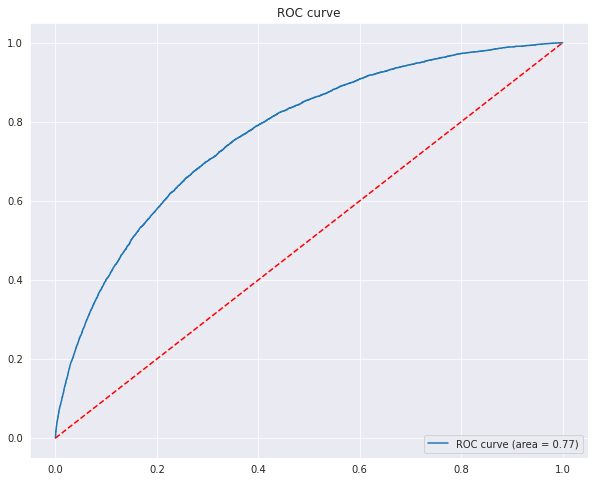

In [ ]:
plot_roc(y_test, y_h_pred)

Plot of the feature importances for the model trained.

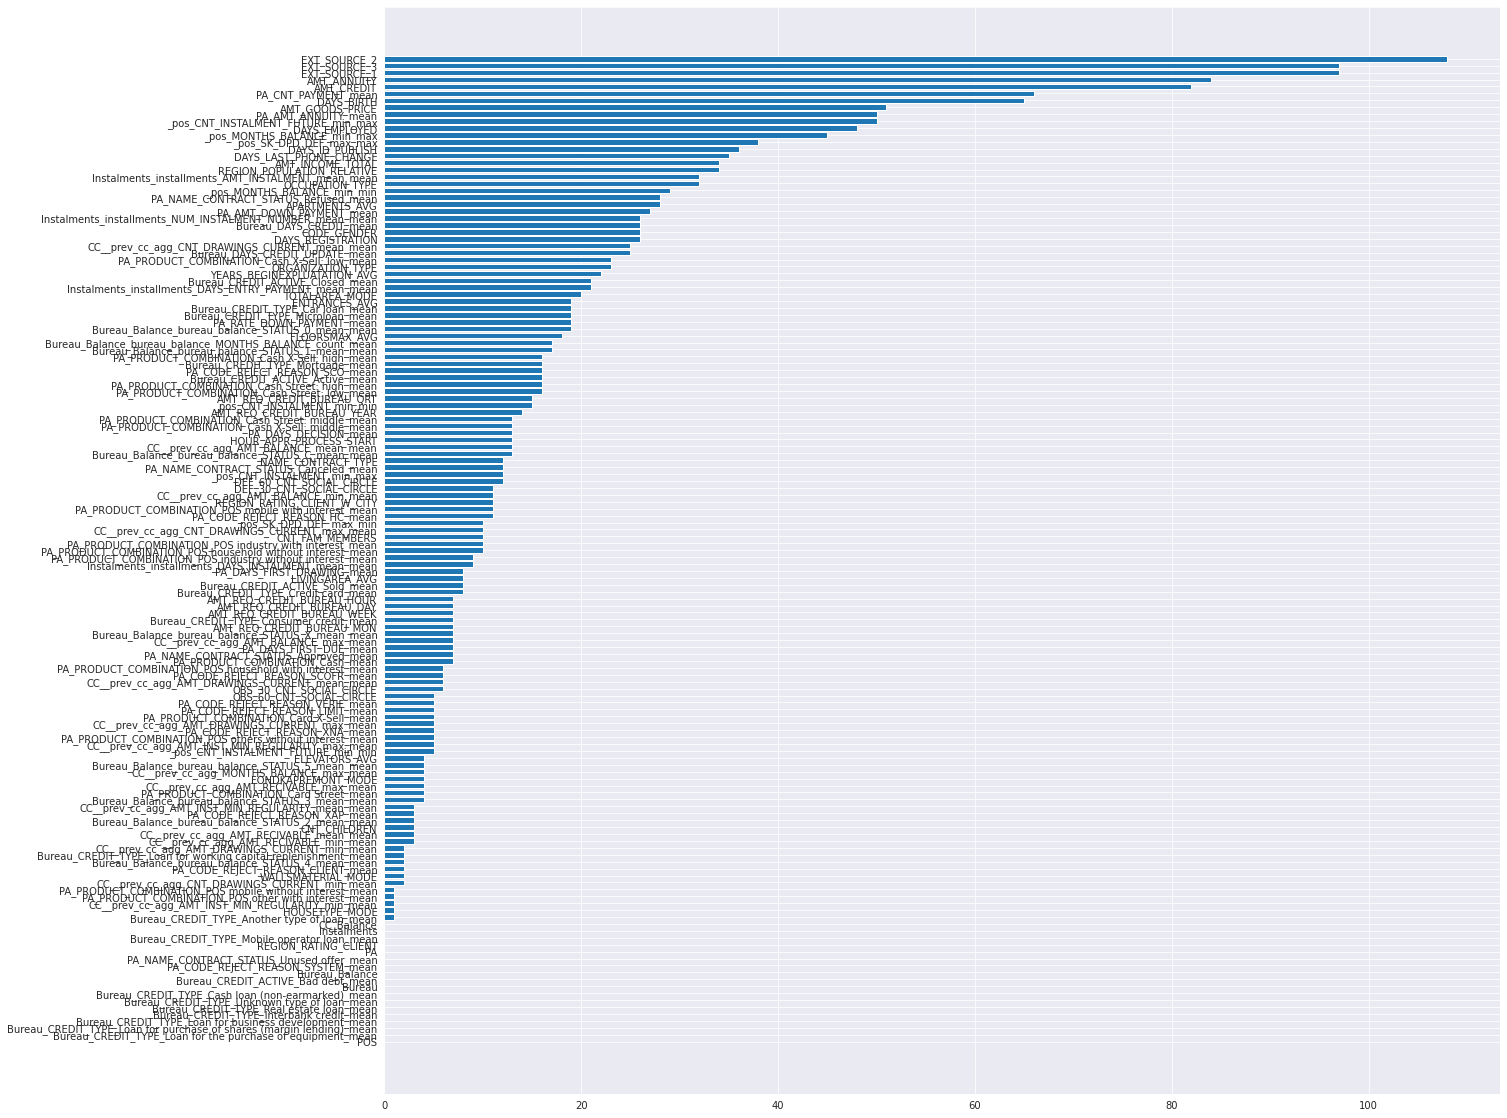

In [ ]:
fi = plot_feature_importances(grid.best_estimator_)

In [ ]:
fi.tail(20)

Feature importance
_pos_MONTHS_BALANCE_min_min                                        29
OCCUPATION_TYPE                                                    32
Instalments_installments_AMT_INSTALMENT_mean_mean                  32
REGION_POPULATION_RELATIVE                                         34
AMT_INCOME_TOTAL                                                   34
DAYS_LAST_PHONE_CHANGE                                             35
DAYS_ID_PUBLISH                                                    36
_pos_SK_DPD_DEF_max_max                                            38
_pos_MONTHS_BALANCE_min_max                                        45
DAYS_EMPLOYED                                                      48
_pos_CNT_INSTALMENT_FUTURE_min_max                                 50
PA_AMT_ANNUITY_mean                                                50
AMT_GOODS_PRICE                                                    51
DAYS_BIRTH                                                         65
PA_CNT_PAYMENT_mean                                                66
AMT_CREDIT                                                         82
AMT_ANNUITY                                                        84
EXT_SOURCE_1                                                       97
EXT_SOURCE_3                                                       97
EXT_SOURCE_2                                                      108

Features that have low or zero importance in the model trained were removed from the dataset seeking the reduction of noise in the model. A new model tuning was applied to verify any improved obtained.

In [ ]:
bureau_credit_type = [ 'Bureau_CREDIT_TYPE_Another type of loan_mean',
 'Bureau_CREDIT_TYPE_Car loan_mean',
 'Bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean',
 'Bureau_CREDIT_TYPE_Consumer credit_mean',
 'Bureau_CREDIT_TYPE_Credit card_mean',
 'Bureau_CREDIT_TYPE_Interbank credit_mean',
 'Bureau_CREDIT_TYPE_Loan for business development_mean',
 'Bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean',
 'Bureau_CREDIT_TYPE_Loan for the purchase of equipment_mean',
 'Bureau_CREDIT_TYPE_Loan for working capital replenishment_mean',
 'Bureau_CREDIT_TYPE_Microloan_mean',
 'Bureau_CREDIT_TYPE_Mobile operator loan_mean',
 'Bureau_CREDIT_TYPE_Mortgage_mean',
 'Bureau_CREDIT_TYPE_Real estate loan_mean',
 'Bureau_CREDIT_TYPE_Unknown type of loan_mean']

In [ ]:
selected_features = list(fi.index)

In [ ]:
for i in bureau_credit_type:
  selected_features.remove(i)

In [ ]:
df_final=df_train[index_target+selected_features]

In [ ]:
df_final

SK_ID_CURR  TARGET    POS  ...  EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2
0           100002       1  False  ...      0.083037      0.139376      0.262949
1           100003       0  False  ...      0.311267      0.518712      0.622246
2           100004       0  False  ...      0.546786      0.729567      0.555912
3           100006       0  False  ...      0.464978      0.544964      0.650442
4           100007       0  False  ...      0.599376      0.549742      0.322738
...            ...     ...    ...  ...           ...           ...           ...
307506      456251       0  False  ...      0.145570      0.450119      0.681632
307507      456252       0  False  ...      0.661750      0.503693      0.115992
307508      456253       0  False  ...      0.744026      0.218859      0.535722
307509      456254       1  False  ...      0.408346      0.661024      0.514163
307510      456255       0  False  ...      0.734460      0.113922      0.708569

[307511 rows x 130 columns]

####Second attempt


In [ ]:
#Dataframe split

x_train, x_test, y_train, y_test = train_test_split(df_final.iloc[:,2:], df_final.iloc[:,1], random_state = 16)

col = list(df_final.columns)
col.pop(0)
col

x = df_final[col]
y = y_train

In [ ]:
gridParams_2 = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 50, 90, 200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [-1],
    'random_state' : [16], 
    'colsample_bytree' : [0.5,0.7, 0.9],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'n_estimators': [100, 250,500],
    'metric':['auc']
    }

In [ ]:
h_clf_2 = lgb.LGBMClassifier()

In [ ]:
grid_2 = RandomizedSearchCV(h_clf_2, gridParams_2, cv=4, verbose=2, n_jobs=-1)
grid_2.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 12.9min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learnin

In [ ]:
grid_2.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'n_estimators': 100,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 16,
 'subsample': 0.5}

In [ ]:
y_h_pred_2 = grid_2.predict_proba(x_test)[:,1]

0.7656050928213145


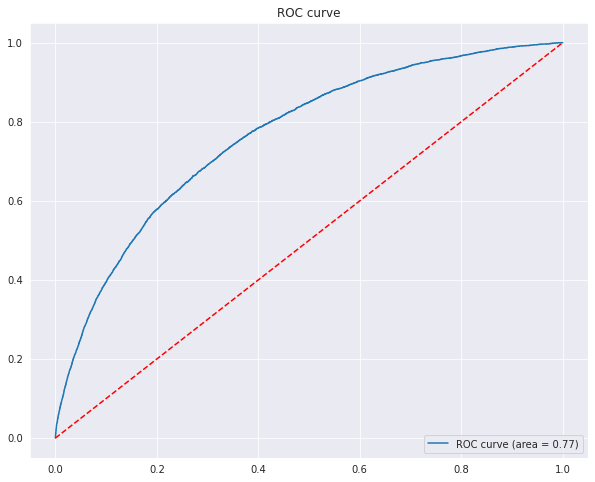

In [ ]:
plot_roc(y_test, y_h_pred_2)

In [ ]:
fi_2 = plot_feature_importances(grid_2.best_estimator_)

Transformation of RandomizedCV into the LGBoost

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    boosting_type= 'gbdt',
    colsample_bytree= 0.9,
    learning_rate= 0.05,
    max_depth= -1,
    metric= 'auc',
    min_data_in_leaf= 10,
    min_split_gain= 0.01,
    n_estimators= 250,
    num_leaves= 10,
    objective= 'binary',
    random_state= 16,
    subsample= 0.7
)

In [ ]:
lgb_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.01, n_estimators=250,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=16,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_lbg = lgb_clf.predict_proba(x_test)[:,1]

In [ ]:
plot_roc(y_test, y_lbg)

####Third attempt - GridSearch

In [ ]:
#Dataframe split

x_train, x_test, y_train, y_test = train_test_split(df_train.iloc[:,2:], df_train.iloc[:,1], random_state = 16)

col = list(df_train.columns)
col.pop(0)
col

x = df_train[col]
y = y_train

In [ ]:
df_train

SK_ID_CURR  TARGET  ...  _pos_SK_DPD_DEF_max_max    POS
0           100002       1  ...                      0.0  False
1           100003       0  ...                      0.0  False
2           100004       0  ...                      0.0  False
3           100006       0  ...                      0.0  False
4           100007       0  ...                      0.0  False
...            ...     ...  ...                      ...    ...
307506      456251       0  ...                      0.0  False
307507      456252       0  ...                      0.0  False
307508      456253       0  ...                      5.0  False
307509      456254       1  ...                      0.0  False
307510      456255       0  ...                      5.0  False

[307511 rows x 145 columns]

In [ ]:
gridParams = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 50, 90, 200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [-1],
    'random_state' : [16], 
    'colsample_bytree' : [0.5,0.7, 0.9],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'n_estimators': [100, 250,500],
    'metric':['auc']
    }

In [ ]:
gs_clf = lgb.LGBMClassifier()

In [ ]:
grid_search = GridSearchCV(gs_clf,
                           gridParams,
                           cv=4, verbose=True, n_jobs=-1)


In [ ]:
grid_search.fit(x_train,y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 84.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 226.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 327.9min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=Tru...
                         'colsample_bytree': [0.5, 0.7, 0.9],
                         'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'metric': ['auc'], 'min_data_in_leaf': [10],
                         'min_split_gain': [0.01],
                

In [ ]:
grid_search.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'n_estimators': 250,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 16,
 'subsample': 0.5}

In [ ]:
y_gs_pred = grid_search.predict_proba(x_test)[:,1]

0.7695235148267547


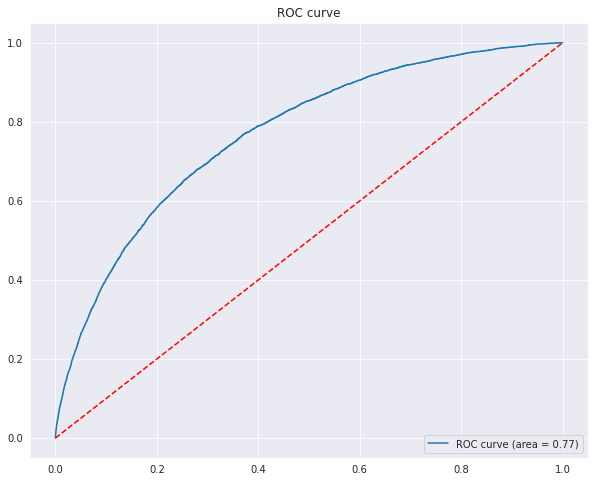

In [ ]:
plot_roc(y_test, y_gs_pred)

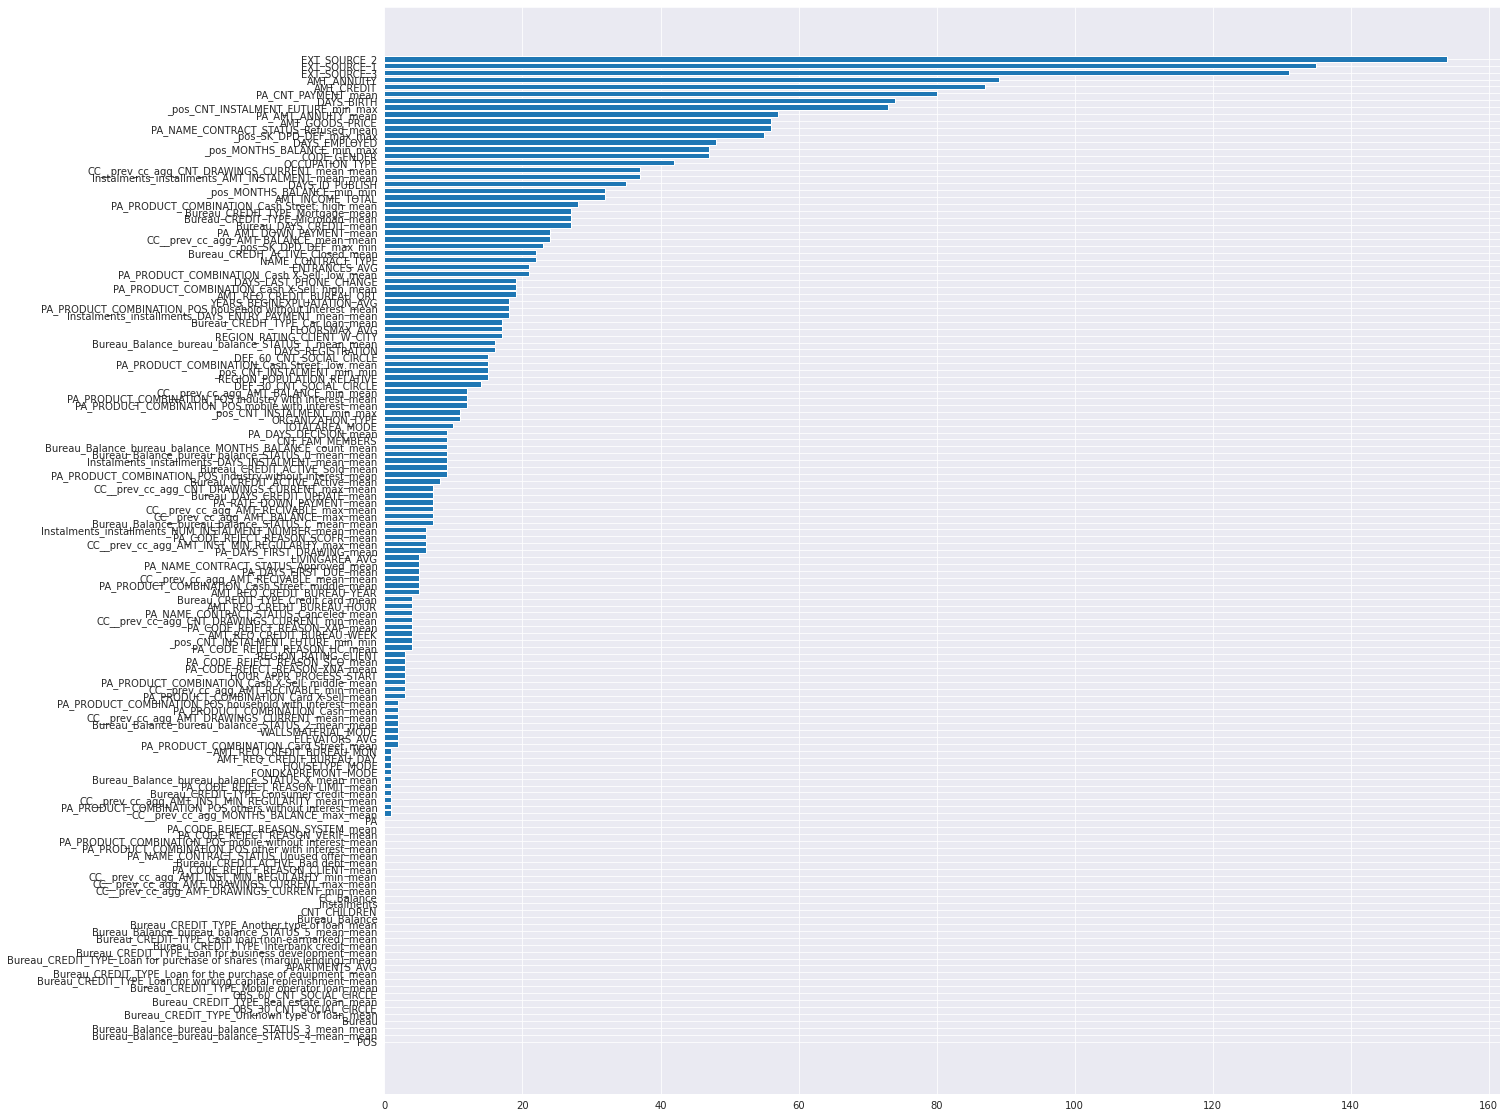

In [ ]:
fi = plot_feature_importances(grid_search.best_estimator_)

In [ ]:
fi.head(20)

Feature importance
POS                                                                  0
Bureau_Balance_bureau_balance_STATUS_4_mean_mean                     0
Bureau_Balance_bureau_balance_STATUS_3_mean_mean                     0
Bureau                                                               0
Bureau_CREDIT_TYPE_Unknown type of loan_mean                         0
OBS_30_CNT_SOCIAL_CIRCLE                                             0
Bureau_CREDIT_TYPE_Real estate loan_mean                             0
OBS_60_CNT_SOCIAL_CIRCLE                                             0
Bureau_CREDIT_TYPE_Mobile operator loan_mean                         0
Bureau_CREDIT_TYPE_Loan for working capital rep...                   0
Bureau_CREDIT_TYPE_Loan for the purchase of equ...                   0
APARTMENTS_AVG                                                       0
Bureau_CREDIT_TYPE_Loan for purchase of shares ...                   0
Bureau_CREDIT_TYPE_Loan for business developmen...                   0
Bureau_CREDIT_TYPE_Interbank credit_mean                             0
Bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean                    0
Bureau_Balance_bureau_balance_STATUS_5_mean_mean                     0
Bureau_CREDIT_TYPE_Another type of loan_mean                         0
Bureau_Balance                                                       0
CNT_CHILDREN                                                         0

Transformation of GridSearchCV into the LGBoost

In [ ]:

lgb_clf_2 = lgb.LGBMClassifier(
 boosting_type= 'gbdt',
 colsample_bytree= 0.7,
 learning_rate= 0.05,
 max_depth= -1,
 metric= 'auc',
 min_data_in_leaf= 10,
 min_split_gain= 0.01,
 n_estimators= 500,
 num_leaves= 10,
 objective= 'binary',
 random_state= 16,
 subsample= 0.5
)



In [ ]:
lgb_clf_2.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.01, n_estimators=500,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=16,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_lbg_2 = lgb_clf_2.predict_proba(x_test)[:,1]

0.7718187483898103


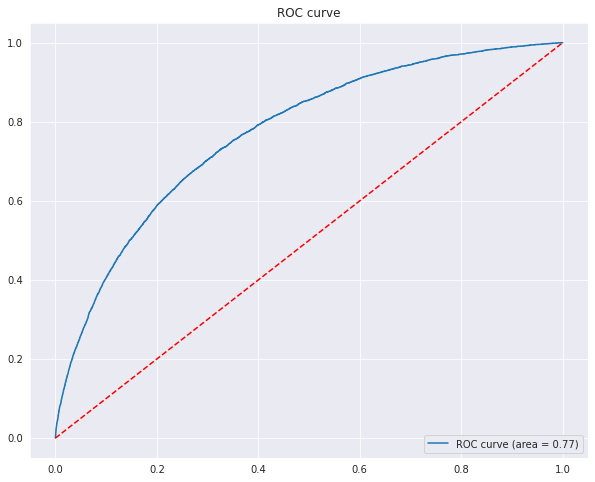

In [ ]:
plot_roc(y_test, y_lbg_2)

Feature selection based in the results obtained from the model trained with the GridSearchCV

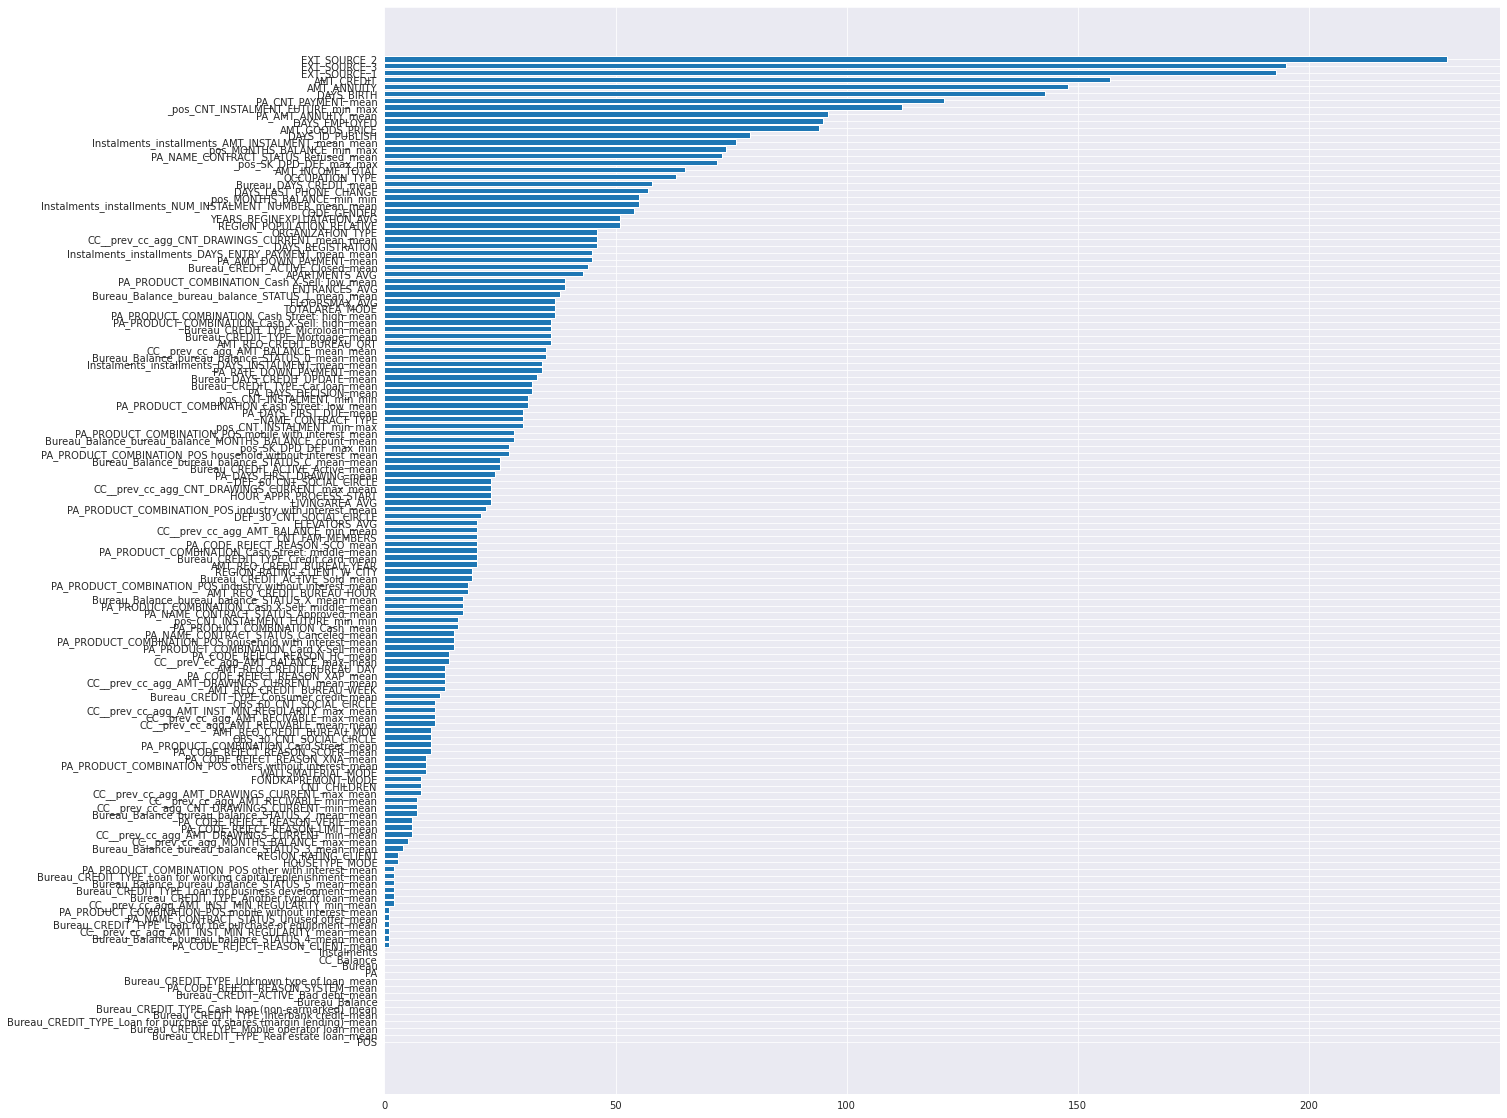

In [ ]:
fi_lgb2 = plot_feature_importances(lgb_clf_2)

In [ ]:
fi_lgb2.head(20)

Feature importance
POS                                                                  0
Bureau_CREDIT_TYPE_Real estate loan_mean                             0
Bureau_CREDIT_TYPE_Mobile operator loan_mean                         0
Bureau_CREDIT_TYPE_Loan for purchase of shares ...                   0
Bureau_CREDIT_TYPE_Interbank credit_mean                             0
Bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean                    0
Bureau_Balance                                                       0
Bureau_CREDIT_ACTIVE_Bad debt_mean                                   0
PA_CODE_REJECT_REASON_SYSTEM_mean                                    0
Bureau_CREDIT_TYPE_Unknown type of loan_mean                         0
PA                                                                   0
Bureau                                                               0
CC_Balance                                                           0
Instalments                                                          0
PA_CODE_REJECT_REASON_CLIENT_mean                                    1
Bureau_Balance_bureau_balance_STATUS_4_mean_mean                     1
CC__prev_cc_agg_AMT_INST_MIN_REGULARITY_mean_mean                    1
Bureau_CREDIT_TYPE_Loan for the purchase of equ...                   1
PA_NAME_CONTRACT_STATUS_Unused offer_mean                            1
PA_PRODUCT_COMBINATION_POS mobile without inter...                   1

##Explainable IA

Two methods were applied to explain the machine learining model trained: SHAP and Lime.

###Lime

The Lime technique is applied to explain why the model came to that probability for a specific observation, in the present case, a client. The implementation of the Lime requires first the determination of an explainer that stores the training data, type of problem and feature names as parameters. Afterwards, we create an instance for the observation to be explained.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = x_train.to_numpy(), mode='classification', feature_names=x_train.columns)

In [ ]:
exp = explainer.explain_instance(x_train.iloc[134].to_numpy(), lgb_clf_2.predict_proba, num_features=10)
  ##visualize the result
exp.show_in_notebook(show_table=True)

The first part present (left) the predicted probability for the observation analyzed (the result). So, the value 0.13 represent the PD of the client in row 134. The centre part represents how much each feature contributed to the final value of the predicted probability. The elevated total number of features in the dataset reduced the contribution of each feature; therefore, there is a trade-off between the number of features and the interpretability of each one to the final result. The last part (right) shows the actual values of the 10 most important feature for that observation, for example, CODE_GENDER equal to 1 indicates that the client is female. Hence, the Lime technique can help to explain the model locally.

###SHAP


To explain the model globally, the SHAP technique can be applied. This technique is based on the Shapley value.

In [ ]:
explainer_shap = shap.TreeExplainer(lgb_clf_2)

In [ ]:
shap_values = explainer_shap.shap_values(x_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


The force plot represents the contribution of each feature to the final result of the model regarding an observation. This presents similarities with the lime; however, in SHAP it is possible to generate this plot for several observations at once. In this plot, features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

In [ ]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][134,:], x_train.iloc[134,:])

Another fundamental plot is the summary plot, which presents the most important features sorted by the feature importance according to the mean SHAP value; therefore, presenting the average impact of that feature on model output magnitude.

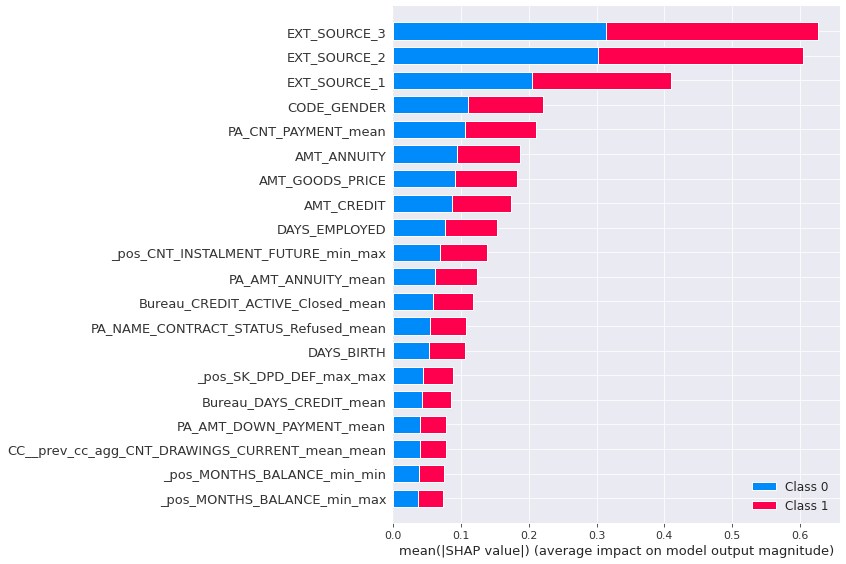

In [ ]:
shap.summary_plot(shap_values, x_train)

Finally, another important visualization from the summary plot can be through a violin plot. This plot is constructed by plotting for each observation a dot with information related to the feature, the effect on the predicted probability, the value of the feature and its correlation with the target.

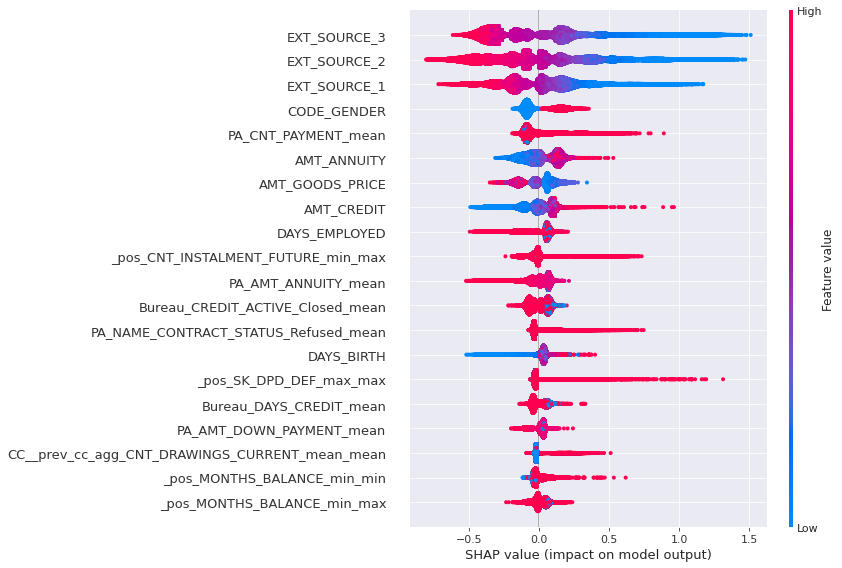

In [ ]:
shap.summary_plot(shap_values[1], x_train)

#Export trained model

In [ ]:
pickle_out = open('model.pkl', 'wb')
pickle.dump(lgb_clf_2, pickle_out)
pickle_out.close()

In [ ]:
list(df_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'FLOORSMAX_AVG',
 'TOTALAREA_MODE',
 'LIVINGAREA_AVG',
 'ELEVATORS_AVG',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'EXT_SOURCE_1',
 'Bureau